In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import statsmodels.api as sm
import pickle as pkl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as smf
from scipy.stats import chi2
from statsmodels.discrete.discrete_model import NegativeBinomial

%matplotlib inline

try:
    import ipympl
except ImportError:
    !pip install ipympl > /dev/null 2>&1



In [2]:
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")




### Welcome to the Final Project.

### In this project, we will analyze a chemical company. The company works with two types of chemicals: Sulfuric_Acid and Methane.

### The company employs workers, each of whom is skilled in handling only one type of chemical and thus works exclusively with that chemical.

### Like any company, this one also experiences workplace accidents caused by the employees. The project will focus on these accidents.

### The company is located in Canada and has factories spread across the country.

### Additionally, each employee undergoes safety tests and receives a score ranging from 1 to 10, with 10 being the highest.

### Part A: Dataset

### As mentioned, the company handles two chemicals: 'Methane' and 'Sulfuric Acid'.

### Sometimes, after using one of the chemicals, residues are left behind, making it difficult to determine which of the two chemicals it is.

### However, we do know the temperature of the residue and whether or not clumps have formed. These two properties can indicate the type of chemical.

### The dataset contains the following columns:

### Intercept: simply a column of ones to add intercept to the model
### temp: the temperture of the chimical
### rigid_left__c: Categorial  - true if there are some lumps. 
### is_mathane: True if mathane, False if Sulfuric Acid

In [3]:
num_group = 10
df_part_1 = pkl.load(open(r"C:\Users\landa\OneDrive\Desktop\לימודים\שנה ב\ניהול בטיחות למהנדסים\project_Semester_B\data_project_semester_b\project_part_1_group_10.pkl", "rb"))
df_part_1.head()

,Intercept,temp,rigid_left__c,is_mathane
0,1.0,33.662545,False,False
1,1.0,37.301490,True,True
2,1.0,33.057068,True,False
3,1.0,44.139356,True,True
4,1.0,46.069813,False,True


# Part A:

### 1. Please build a logistic regression model to predict the probability that the substance is Methane. The final prediction equation should be presented.

### Next, we want to classify whether the substance is 'Methane' or 'Sulfuric Acid'.
### For consistency, we will define Methane as 1 and Sulfuric Acid as 0.

### 2. Is there a threshold value for classification where both sensitivity and specificity are above 0.6? If so, what is the range of threshold values that meet this criterion?

### 3. What is the threshold that maximizes accuracy? If there is more than one, please specify the range.

### What is the probability that the substance is Methane in the following three cases:

#### a. Temperature is 25.5°C and residues remain.

#### b. Temperature is 26.5°C and residues remain.

#### c. Temperature is 27.5°C and residues remain.

### 4. What is the log-odds ratio between (b) and (a), (c) and (b), and (c) and (a)?

### Are the three values you obtained equal? Are any of them equal? Please explain the significance of the results you obtained.

## 1. Logistic regression model

In [4]:
df_part_1['rigid_left__c'] = df_part_1['rigid_left__c'].astype(int)
df_part_1['is_mathane'] = df_part_1['is_mathane'].astype(int)
df_part_1.head()

,Intercept,temp,rigid_left__c,is_mathane
0,1.0,33.662545,0,0
1,1.0,37.301490,1,1
2,1.0,33.057068,1,0
3,1.0,44.139356,1,1
4,1.0,46.069813,0,1


In [5]:
model_logistic = sm.Logit(df_part_1['is_mathane'], df_part_1[['Intercept','temp','rigid_left__c']],)
results_logistic = model_logistic.fit()
print(results_logistic.summary())

Optimization terminated successfully.
         Current function value: 0.556052
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             is_mathane   No. Observations:                  120
Model:                          Logit   Df Residuals:                      117
Method:                           MLE   Df Model:                            2
Date:                Wed, 21 Aug 2024   Pseudo R-squ.:                  0.1898
Time:                        09:25:33   Log-Likelihood:                -66.726
converged:                       True   LL-Null:                       -82.359
Covariance Type:            nonrobust   LLR p-value:                 1.625e-07
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.7808      0.785      4.817      0.000       2.242       5.319
temp             -0.

### The final prediction equation
Logit(p)=3.7808−0.0934×temp−1.0551×rigid_left__c

## 2. Threshold value for classification where both sensitivity and specificity are above 0.6:

In [6]:
df_part_1['predicted_probability_Methane'] = results_logistic.predict(df_part_1[['Intercept', 'temp', 'rigid_left__c']])
df_part_1.head()

,Intercept,temp,rigid_left__c,is_mathane,predicted_probability_Methane
0,1.0,33.662545,0,0,0.653756
1,1.0,37.301490,1,1,0.318747
2,1.0,33.057068,1,0,0.410242
3,1.0,44.139356,1,1,0.198066
4,1.0,46.069813,0,1,0.371995


In [7]:
thresholds = np.arange(0.0, 1.0, 0.01)
valid_thresholds = []

for threshold in thresholds:
    df_part_1['classification'] = df_part_1['predicted_probability_Methane'].apply(lambda x: 1 if x > threshold else 0)
    
    TP = df_part_1.loc[(df_part_1['is_mathane'] == 1) & (df_part_1['classification'] == 1), :].shape[0]
    FP = df_part_1.loc[(df_part_1['is_mathane'] == 0) & (df_part_1['classification'] == 1), :].shape[0]
    TN = df_part_1.loc[(df_part_1['is_mathane'] == 0) & (df_part_1['classification'] == 0), :].shape[0]
    FN = df_part_1.loc[(df_part_1['is_mathane'] == 1) & (df_part_1['classification'] == 0), :].shape[0]

    sensativity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    if     sensativity  > 0.6 and specificity > 0.6:
        valid_thresholds.append(threshold)

if valid_thresholds:
    min_threshold = min(valid_thresholds)
    max_threshold = max(valid_thresholds)
    print(f'The valid threshold range is from {min_threshold:.2f} to {max_threshold:.2f}')
else:
    print("No valid thresholds found where both Accuracy and Specificity are above 0.6")


The valid threshold range is from 0.44 to 0.63


## 3. The threshold that maximizes accuracy

In [8]:
thresholds = np.arange(0.0, 1.0, 0.01)
max_accuracy = 0
best_thresholds = []

for threshold in thresholds:
    df_part_1['classification'] = df_part_1['predicted_probability_Methane'].apply(lambda x: 1 if x > threshold else 0)
    
    TP = df_part_1.loc[(df_part_1['is_mathane'] == 1) & (df_part_1['classification'] == 1), :].shape[0]
    FP = df_part_1.loc[(df_part_1['is_mathane'] == 0) & (df_part_1['classification'] == 1), :].shape[0]
    TN = df_part_1.loc[(df_part_1['is_mathane'] == 0) & (df_part_1['classification'] == 0), :].shape[0]
    FN = df_part_1.loc[(df_part_1['is_mathane'] == 1) & (df_part_1['classification'] == 0), :].shape[0]

    accuracy = (TP + TN) / (TP + FP + TN + FN)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_thresholds = [threshold]
    elif accuracy == max_accuracy:
           best_thresholds.append(threshold)

min_threshold = min(best_thresholds)
max_threshold = max(best_thresholds)

if len(best_thresholds) == 1:
    print(f'The maximum accuracy of {max_accuracy:.2f} is achieved at a single threshold of {min_threshold:.2f}')
else:
    print(f'The maximum accuracy of {max_accuracy:.2f} is achieved over the threshold range of {min_threshold:.2f} to {max_threshold:.2f}')


The maximum accuracy of 0.73 is achieved over the threshold range of 0.46 to 0.48


## The probability that the substance is Methane in the following three cases: 
    
### a. Temperature is 25.5°C and residues remain.
    

In [9]:
temp = 25.5
rigid_left__c = 1
intercept = 3.7808
coef_temp = -0.0934
coef_rigid_left__c = -1.0551
odds1 = intercept + coef_temp * temp + coef_rigid_left__c * rigid_left__c
odds1

0.3440000000000003

    
### b. Temperature is 26.5°C and residues remain.
  

In [10]:
temp = 26.5
rigid_left__c = 1
intercept = 3.7808
coef_temp = -0.0934
coef_rigid_left__c = -1.0551
odds2 = intercept + coef_temp * temp + coef_rigid_left__c * rigid_left__c
odds2

0.2506000000000004


### . Temperature is 27.5°C and residues remain.    

In [11]:
temp = 27.5
rigid_left__c = 1
intercept = 3.7808
coef_temp = -0.0934
coef_rigid_left__c = -1.0551
odds3 = intercept + coef_temp * temp + coef_rigid_left__c * rigid_left__c
odds3

0.15720000000000045

## 4. Log-odds ratio between

### (b) and (a)

In [12]:
or1 = (odds2 / (1 - odds2)) / (odds1 / (1 - odds1))
log_or1 = np.log(or1)

print("OR1:", or1)
print("log OR1:", log_or1)

OR1: 0.6376946518455079
log OR1: -0.44989571232692765


### (c) and (b)

In [13]:
or2 = (odds3 / (1 - odds3)) / (odds2 / (1 - odds2))
log_or2 = np.log(or2)

print("OR2:", or2)
print("log OR2:", log_or2)

OR2: 0.5577770446325125
log OR2: -0.5837959580373073


###  (c) and (a)

In [14]:
or3 = (odds3 / (1 - odds3)) / (odds1 / (1 - odds1))
log_or3 = np.log(or3)

print("OR3:", or3)
print("log OR3:", log_or3)

OR3: 0.3556914382843464
log OR3: -1.033691670364235


The log value measured refers to the comparison between different temperature groups. The first value, -0.450, is the log of the odds ratio between a temperature of 26.5°C and 25.5°C. The second value, -0.584, is the log of the odds ratio between a temperature of 27.5°C and 26.5°C. The third value, -1.034, is the log of the odds ratio between a temperature of 27.5°C and 25.5°C. 

Each negative log OR value indicates a decrease in the likelihood of the event occurring at the higher temperature. Larger negative values represent a more significant decrease in probability. Therefore, the lower temperature (25.5°C) is associated with a higher likelihood of the event occurring compared to the higher temperatures.

# Part B:

### Below is the dataset for Part B.

### Each row provides data on how long an employee has been with the company, the type of chemical they work with, the employee's age, the location of the factory, their safety test scores, and the number of accidents they have experienced during their tenure at the factory.

### Intercept: simply a column of ones to add intercept to the model
### age: the worker's age
### safety_guidence_score: the score of safety test a worker is taking - can be any number between 0 to 10
### factory__c: categorial variabal which indicate the factory
### chemical__c: there are two chemicals in which workers are working with: Methane and Sulfuric_Acid
### time_in_factory: the number of years the worker in the factory
### num_accident: the total nnumber of accidents the worker had during his time in the factory


In [15]:
num_group = 10
df_part_2 = pkl.load(open(r"C:\Users\landa\OneDrive\Desktop\לימודים\שנה ב\ניהול בטיחות למהנדסים\project_Semester_B\data_project_semester_b\project_part_2_group_10.pkl", "rb"))
df_part_2.head()

,Intercept,age,safety_guidence_score,factory__c,chemical__c,time_in_factory,num_accidents
0,1.0,47,3,Vancouver,Sulfuric_Acid,1,1
1,1.0,48,9,Vancouver,Sulfuric_Acid,3,0
2,1.0,35,2,Vancouver,Sulfuric_Acid,5,9
3,1.0,23,7,Vancouver,Sulfuric_Acid,1,2
4,1.0,29,10,Toronto,Sulfuric_Acid,10,17


### Here are the tasks:

### 1. Please present a bar chart of the categorical variable `factory__c`, showing the average number of accidents per year of work for each factory.

### Based on the results, does it seem that this variable will be statistically significant and included in the model? Please explain.

### 2. Create a graph showing the number of accidents per single year as a function of age. Since each age appears multiple times in the dataset, you should aggregate the data for each age. Does there appear to be a relationship between the two? If so, what would be the sign of the age coefficient in a regression equation?

### 3. Perform a Poisson regression, including the model and finally presenting the final equation. 
#### Note: For categorical variables, use `Toronto` and `Methane` as the baseline categories.

### 4. Is Poisson regression appropriate here? Please explain and check this using four different methods.

### 5. In one of the model assumption tests, we want to show that approximately 95% of the errors are within ±2 standard deviations. Why does this test help to understand the model assumptions? What exactly do we assume when performing Poisson regression?

### 6. When testing the assumption that the mean equals the variance, we divide the data into buckets and check this condition in each. Why? Why not simply calculate the variance and mean of the dependent variable in the dataset and see if they are equal?

### 7. If the answer to question 4 was no, perform a negative binomial regression and check if it fits here. 
#### If the answer to question 7 is yes, calculate the IRR of one of the continuous variables and explain its significance in terms of the number of accidents.

### 8. According to the regression equation you obtained, what is the expected number of accidents for a 30-year-old worker who scored 8 on a safety test after 3 years of work at the factory? Use only the baseline categories for the categorical variables.

### 9. What is the significance of the result you obtained? What exactly does this number represent?

### 10. Predictions: Please present a 3D graph of the number of accidents over a period of 5 years at a factory in Toronto for Methane, as a function of age and safety test score.

### 11. Theoretical Question: What is the difference between Poisson regression and linear regression in terms of finding parameter values? In what way is linear regression advantageous in this regard?

## 1. Average number of accidents per year of work for each factory.

In [16]:
df_part_2['avg_accidents_per_year'] = df_part_2['num_accidents'] / df_part_2['time_in_factory']
average_accidents_per_factory = df_part_2.groupby('factory__c')['avg_accidents_per_year'].sum().reset_index()
average_accidents_per_factory = average_accidents_per_factory.sort_values(by='avg_accidents_per_year', ascending=True)
df_part_2.head()

,Intercept,age,safety_guidence_score,factory__c,chemical__c,time_in_factory,num_accidents,avg_accidents_per_year
0,1.0,47,3,Vancouver,Sulfuric_Acid,1,1,1.0
1,1.0,48,9,Vancouver,Sulfuric_Acid,3,0,0.0
2,1.0,35,2,Vancouver,Sulfuric_Acid,5,9,1.8
3,1.0,23,7,Vancouver,Sulfuric_Acid,1,2,2.0
4,1.0,29,10,Toronto,Sulfuric_Acid,10,17,1.7


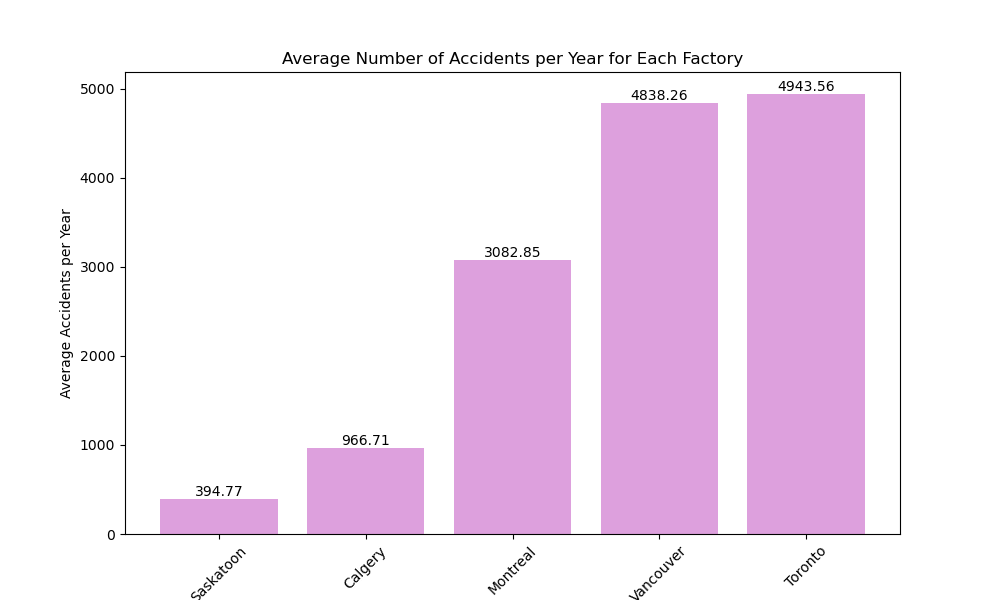

In [17]:
plt.figure(figsize=(10, 6))  
bars = plt.bar(
    average_accidents_per_factory['factory__c'], 
    average_accidents_per_factory['avg_accidents_per_year'], 
    color='plum')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel('Factory')
plt.ylabel('Average Accidents per Year')
plt.title('Average Number of Accidents per Year for Each Factory')
plt.xticks(rotation=45)
plt.show()

This variable will be statistically significant and included in the model, as we can see from the graph that the total number of accidents varies from one factory to another.

In [18]:
df_part_2['Sulfuric_Acid'] = df_part_2['chemical__c'].apply(lambda x: 1 if x == 'Sulfuric_Acid' else 0)
df_part_2['Methane'] = df_part_2['chemical__c'].apply(lambda x:1 if x == 'Methane' else 0)
df_part_2['Calgery'] = df_part_2['factory__c'].apply(lambda x: 1 if x == 'Calgery' else 0)
df_part_2['Montreal'] = df_part_2['factory__c'].apply(lambda x:1 if x == 'Montreal' else 0)
df_part_2['Saskatoon'] = df_part_2['factory__c'].apply(lambda x: 1 if x == 'Saskatoon' else 0)
df_part_2['Toronto'] = df_part_2['factory__c'].apply(lambda x: 1 if x == 'Toronto' else 0)
df_part_2['Vancouver'] = df_part_2['factory__c'].apply(lambda x: 1 if x == 'Vancouver' else 0)
df_part_2.head(10)

,Intercept,age,safety_guidence_score,factory__c,chemical__c,time_in_factory,num_accidents,avg_accidents_per_year,Sulfuric_Acid,Methane,Calgery,Montreal,Saskatoon,Toronto,Vancouver
0,1.0,47,3,Vancouver,Sulfuric_Acid,1,1,1.0,1,0,0,0,0,0,1
1,1.0,48,9,Vancouver,Sulfuric_Acid,3,0,0.0,1,0,0,0,0,0,1
2,1.0,35,2,Vancouver,Sulfuric_Acid,5,9,1.8,1,0,0,0,0,0,1
3,1.0,23,7,Vancouver,Sulfuric_Acid,1,2,2.0,1,0,0,0,0,0,1
4,1.0,29,10,Toronto,Sulfuric_Acid,10,17,1.7,1,0,0,0,0,1,0
5,1.0,30,2,Vancouver,Sulfuric_Acid,8,36,4.5,1,0,0,0,0,0,1
6,1.0,37,2,Toronto,Sulfuric_Acid,10,15,1.5,1,0,0,0,0,1,0
7,1.0,40,3,Toronto,Sulfuric_Acid,1,0,0.0,1,0,0,0,0,1,0
8,1.0,28,3,Toronto,Sulfuric_Acid,1,0,0.0,1,0,0,0,0,1,0
9,1.0,32,4,Vancouver,Methane,8,20,2.5,0,1,0,0,0,0,1


## 2. Graph showing the number of accidents per single year as a function of age.

In [19]:
df_avg_accidents = df_part_2.groupby('age')['avg_accidents_per_year'].mean().reset_index()
df_avg_accidents['Intercept'] = 1.0
df_avg_accidents.head()

,age,avg_accidents_per_year,Intercept
0,23,1.592943,1.0
1,24,1.606957,1.0
2,25,1.627878,1.0
3,26,1.536079,1.0
4,27,1.642903,1.0


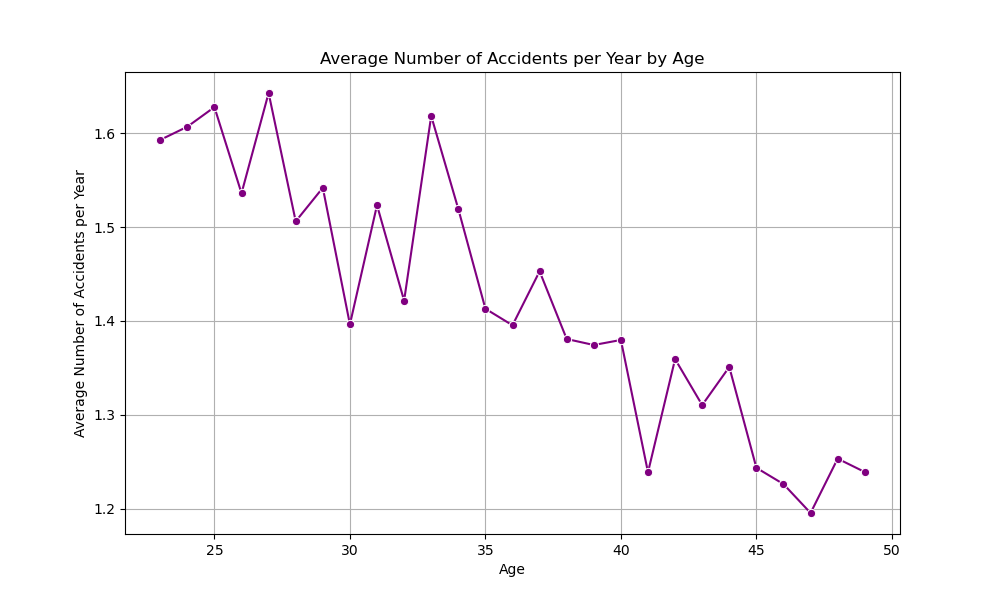

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_avg_accidents, x='age', y='avg_accidents_per_year', marker='o', color='purple')  
plt.title('Average Number of Accidents per Year by Age')
plt.xlabel('Age')
plt.ylabel('Average Number of Accidents per Year')
plt.grid(True)
plt.show()

It can be observed that there is a relationship between the employee's age and the average number of accidents per year—the older the employee, the fewer accidents they tend to have.  
The age coefficient will be negative because as age increases, the likelihood of an accident decreases.

## 3.  Poisson regression

In [21]:
model_poisson2 = sm.GLM(df_part_2['num_accidents'],df_part_2[['Intercept', 'age','safety_guidence_score','time_in_factory','Sulfuric_Acid','Calgery','Montreal','Saskatoon', 'Vancouver'	  ]] , family=sm.families.Poisson())  # Poisson regression model
results_poisson2 = model_poisson2.fit()
print(results_poisson2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_accidents   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9991
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32717.
Date:                Wed, 21 Aug 2024   Deviance:                       32620.
Time:                        09:25:34   Pearson chi2:                 3.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9961
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

We'll remove all the non-significant variables.

In [22]:
model_poisson2 = sm.GLM(df_part_2['num_accidents'],df_part_2[['Intercept', 'age','safety_guidence_score','time_in_factory','Sulfuric_Acid','Calgery', 'Vancouver'	  ]] , family=sm.families.Poisson())  # Poisson regression model
results_poisson2 = model_poisson2.fit()
print(results_poisson2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_accidents   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32719.
Date:                Wed, 21 Aug 2024   Deviance:                       32623.
Time:                        09:25:34   Pearson chi2:                 3.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9961
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

#### Result = 0.279 -0.0118 * age +0.009 * safety_guidence_score +0.29 * time_in_factory +0.2709 * chemical__c_BIN + 0.0498 *Calgery +0.4113 * Vancouver                

## 4. Checking using four different method

### A. Is the mean equal to the variance?

The issue is that for each mean, there is often only a single data point, but to check variance, we need to examine the spread. It's impossible to assess the spread without having multiple data points. Therefore, we'll use a method called bucketing.

This means we'll divide the data points into several regions, and within each region, we'll calculate the mean and variance.

It looks like this:

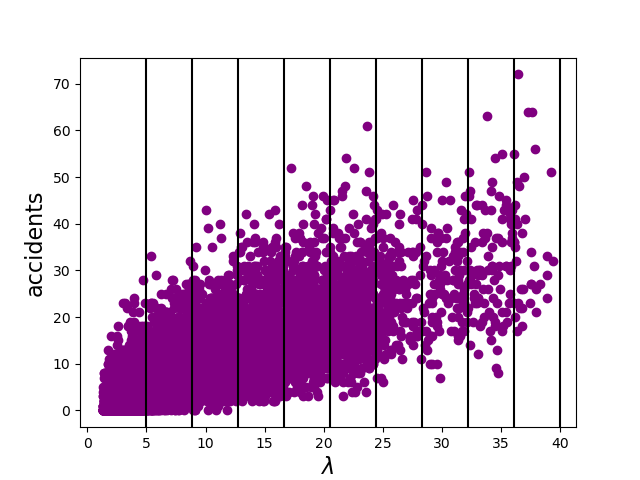

In [23]:
df_part_2['results_poisson'] = results_poisson2.fittedvalues
plt.figure()
plt.scatter(df_part_2['results_poisson'], df_part_2['num_accidents'], color='purple')
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('accidents', fontsize = 16)
for x_val in np.linspace(5,40, 10):
    plt.axvline(x=x_val, color= 'black')
plt.show()

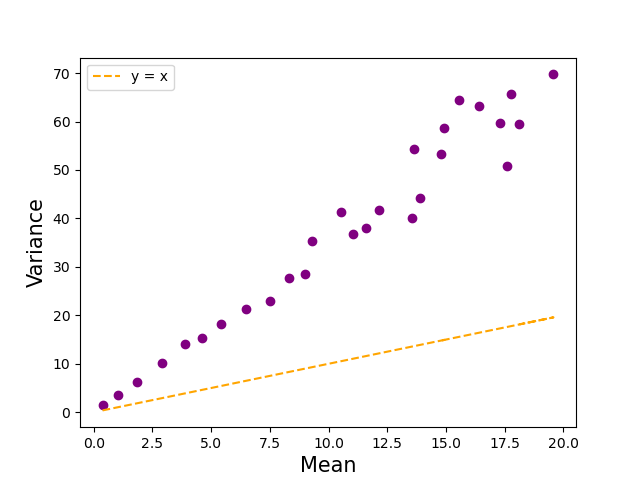

In [24]:
lams = np.linspace(0, 20, 30)

means = []
vars_ = []

for lams_ind in range(lams.shape[0]-1):
    
    lb = lams[lams_ind]
    ub = lams[lams_ind+1]
        
    shape = df_part_2.loc[(df_part_2['results_poisson']>lb)& (df_part_2['results_poisson']<ub), 'num_accidents'].shape
    var = df_part_2.loc[(df_part_2['results_poisson']>lb)& (df_part_2['results_poisson']<ub), 'num_accidents'].std()**2
    mean = df_part_2.loc[(df_part_2['results_poisson']>lb)& (df_part_2['results_poisson']<ub), 'num_accidents'].mean()
    
    if shape[0] > 20:
        means.append(mean)
        vars_.append(var)
    
plt.figure()
plt.scatter(means, vars_, color='purple')  
plt.plot(means, means, '--', label='y = x', color='orange')
plt.xlabel('Mean', fontsize=15)
plt.ylabel('Variance', fontsize=15)
plt.legend()
plt.show()


We can see that the variance and the mean increase in the "same direction" but not at the "same rate."

### B. A standard deviation of ±2.

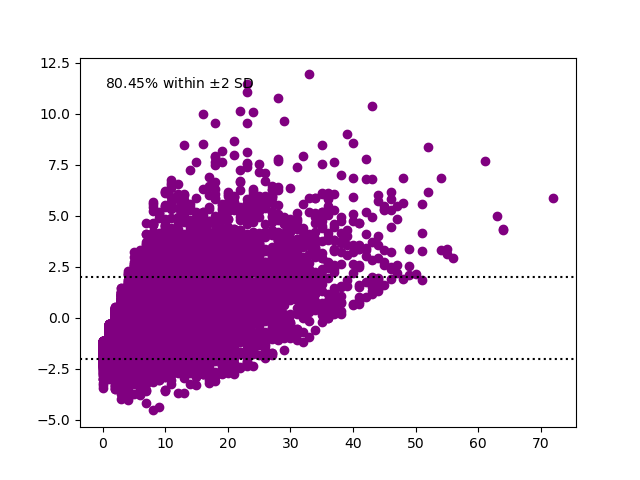

In [25]:
num_within_2sd = ((results_poisson2.resid_pearson >= -2) & (results_poisson2.resid_pearson <= 2)).sum()
total_points = len(results_poisson2.resid_pearson)
percentage_within_2sd = (num_within_2sd / total_points) * 100

plt.figure()
plt.scatter(df_part_2['num_accidents'], results_poisson2.resid_pearson, color='purple')  # Changed color to purple
plt.axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
plt.axhline(y=+2, linestyle=':', color='black')

plt.text(0.05, 0.95, f'{percentage_within_2sd:.2f}% within $\pm$2 SD',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.show()

It can be observed that most of the data does not fall within the desired range, indicating that Poisson regression is less suitable according to this test.

### C. Actual variance versus expected variance

In [26]:
R = results_poisson2.pearson_chi2 / results_poisson2.df_resid
print(R)

3.379437947307386


This metric helps determine whether there is a need to improve the model or switch to a different model to achieve more accurate and reliable results. If this measure is high and far from 1, it indicates that the Poisson model may not be suitable for the data.

### D. Hypothesis Testing

In [27]:
df1 = results_poisson2.df_resid
p_value = 1 - chi2.cdf(results_poisson2.pearson_chi2,df1)
p_value

0.0

A low p-value (for example, below 0.05) indicates that the actual variance is significantly higher than the variance expected according to the Poisson model. This may suggest an issue of overdispersion, and it could mean that an alternative model is needed.

## Summary:
Based on all four tests, it is evident that Poisson regression is not suitable for our data.

## 5. Testing ±2 Standard Deviations

This test helps to understand if the model assumptions are met. Specifically, it checks whether approximately 95% of the errors fall within ±2 standard deviations from the mean.

If this condition is met, it suggests that the Poisson model’s assumption—that the variance equals the mean—is reasonably satisfied. If not, it indicates that the model may not fit the data well, and alternative models or adjustments might be necessary.

## 6.Divide the data into buckets:

The issue is that for each mean, there is often only a single data point, but to assess variance, we need to examine the spread. It's impossible to assess the spread without having multiple data points. Therefore, we use a method called bucketing.

This involves dividing the data points into several regions and calculating the mean and variance within each region.

## 7. Negative binomial regression

In [28]:
print(df_part_2.columns)

Index(['Intercept', 'age', 'safety_guidence_score', 'factory__c',
       'chemical__c', 'time_in_factory', 'num_accidents',
       'avg_accidents_per_year', 'Sulfuric_Acid', 'Methane', 'Calgery',
       'Montreal', 'Saskatoon', 'Toronto', 'Vancouver', 'results_poisson'],
      dtype='object')


In [29]:
X = df_part_2[['Intercept', 'age', 'safety_guidence_score', 'Calgery', 'Montreal', 'Saskatoon', 'Vancouver', 'Sulfuric_Acid']]
y = df_part_2['num_accidents']
nb = NegativeBinomial(
    y,
    X,
    offset=np.log(df_part_2["time_in_factory"].values),
)

result = nb.fit()
print(pd.DataFrame(result.params).loc['alpha',:])

Optimization terminated successfully.
         Current function value: 2.847420
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
0    0.364307
Name: alpha, dtype: float64


In [30]:
pd.DataFrame(result.params).loc['alpha',:]

0    0.364307
Name: alpha, dtype: float64

In [31]:
alpha = 0.364307
model_NB = sm.GLM(
    y,
    X,  
    offset=np.log(df_part_2["time_in_factory"]),  
    family=sm.families.NegativeBinomial(alpha=alpha),
)

result_NB = model_NB.fit()
print(result_NB.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_accidents   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9992
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28474.
Date:                Wed, 21 Aug 2024   Deviance:                       12053.
Time:                        09:25:35   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07558
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.64

We'll remove all the non-significant variables.

In [32]:
X = df_part_2[['Intercept', 'age', 'safety_guidence_score', 'Calgery', 'Vancouver']]
y = df_part_2['num_accidents']
nb = NegativeBinomial(
    y,
    X,
    offset=np.log(df_part_2["time_in_factory"].values),
)

result = nb.fit()

print(pd.DataFrame(result.params).loc['alpha',:])

Optimization terminated successfully.
         Current function value: 2.847532
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
0    0.364488
Name: alpha, dtype: float64


In [33]:
alpha = 0.364488
model_NB = sm.GLM(
    y,
    X, 
    offset=np.log(df_part_2["time_in_factory"]), 
    family=sm.families.NegativeBinomial(alpha=alpha),)
result_NB = model_NB.fit()
print(result_NB.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          num_accidents   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28475.
Date:                Wed, 21 Aug 2024   Deviance:                       12052.
Time:                        09:25:35   Pearson chi2:                 1.00e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07534
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.62

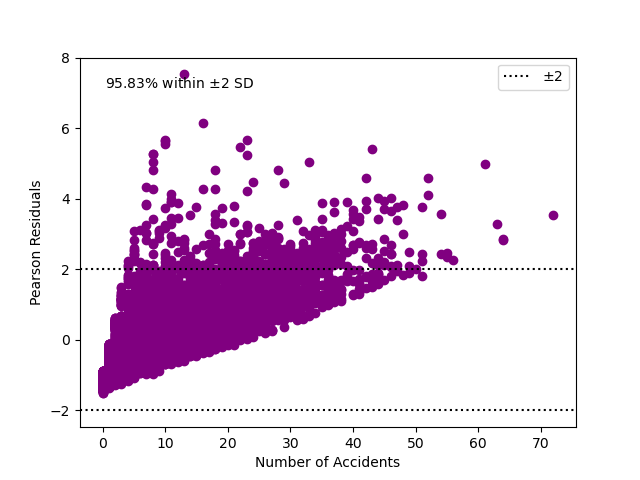

In [34]:
df_part_2['results_negative_binomial'] = result_NB.fittedvalues

num_within_2sd = ((result_NB.resid_pearson >= -2) & (result_NB.resid_pearson <= 2)).sum()
total_points = len(result_NB.resid_pearson)
percentage_within_2sd = (num_within_2sd / total_points) * 100

plt.figure()
plt.scatter(df_part_2['num_accidents'], result_NB.resid_pearson, color='purple')  
plt.axhline(y=-2, linestyle=':', color='black', label='$\pm 2$')
plt.axhline(y=+2, linestyle=':', color='black')

plt.text(0.05, 0.95, f'{percentage_within_2sd:.2f}% within $\pm$2 SD',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')

plt.xlabel('Number of Accidents')
plt.ylabel('Pearson Residuals')
plt.legend()
plt.show()

It can be observed that in the negative binomial regression, most values (over 95%) fall within the ±2 range, indicating that the negative binomial regression is indeed suitable for the data.

## 8. The expected number of accidents for a 30-year-old worker who scored 8 on a safety test after 3 years of work at the factory

In [37]:
intercept = 0.6228
beta_age = -0.0107
beta_safety = 0.0087
age = 30
safety_guidence_score = 8
time_in_factory = 3 
log_time = np.log(time_in_factory)
location = 'Toronto'  
log_expected_accidents = (intercept +beta_age * age +beta_safety * safety_guidence_score  +log_time)
expected_accidents = np.exp(log_expected_accidents)
print(f"expected number of accident: {expected_accidents:.2f}")

expected number of accident: 4.35


## 9. The significance of the result

The result of "4.35" means that the forecasted number of accidents for a 30-year-old employee, who has a safety score of 8 and has worked for 3 years at a factory in Toronto using Methane, is 4.35 accidents.

This indicates that, according to the model, the employee is expected to experience an average of 4.35 accidents during the three years working at the factory.

## 10. A 3D graph of the number of accidents over a period of 5 years at a factory in Toronto for Methane, as a function of age and safety test score.

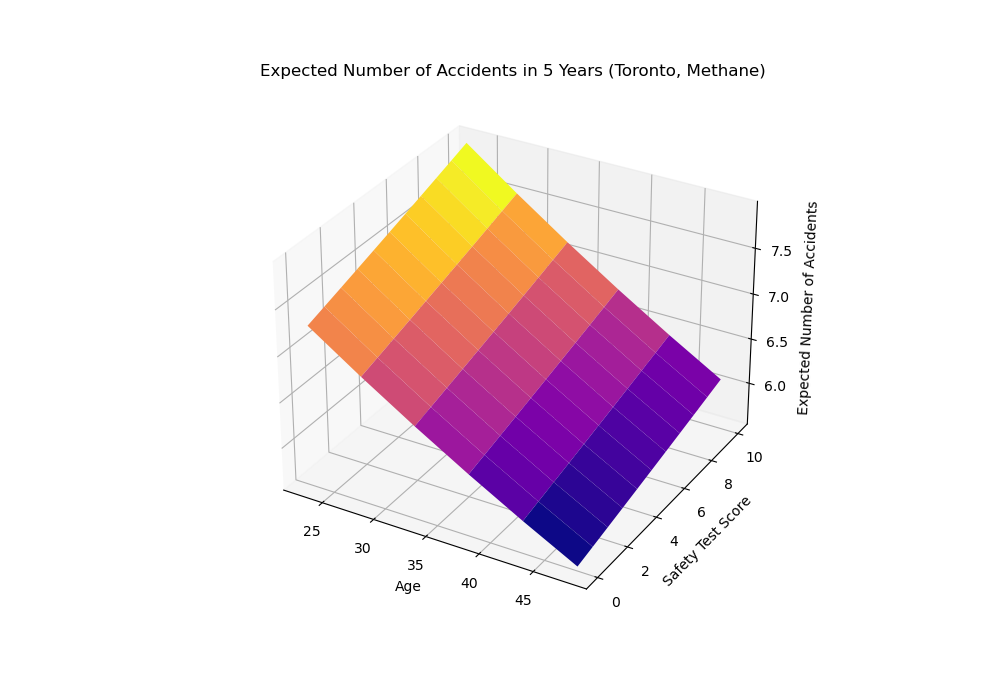

In [36]:
from mpl_toolkits.mplot3d import Axes3D
ages = np.arange(23, 50, 5)  
safety_scores = np.arange(0, 11, 1)  
age_grid, safety_score_grid = np.meshgrid(ages, safety_scores)
expected_accidents = np.zeros_like(age_grid, dtype=float)

for i in range(age_grid.shape[0]):
    for j in range(age_grid.shape[1]):
        linear_predictor = (
            result_NB.params['Intercept'] +
            result_NB.params['age'] * age_grid[i, j] +
            result_NB.params['safety_guidence_score'] * safety_score_grid[i, j] +
            result_NB.params.get('Calgery', 0) * 0 +  
            result_NB.params.get('Vancouver', 0) * 0  
        )
        linear_predictor += np.log(5)
        
        expected_accidents[i, j] = np.exp(linear_predictor)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(age_grid, safety_score_grid, expected_accidents, cmap='plasma')

ax.set_xlabel('Age')
ax.set_ylabel('Safety Test Score')
ax.set_zlabel('Expected Number of Accidents')
ax.set_title('Expected Number of Accidents in 5 Years (Toronto, Methane)')

plt.show()

## 11. The difference between Poisson regression and linear regression

### Linear Regression vs. Poisson Regression

**Linear Regression:**
- **Applicability:** Suitable for cases where the dependent variable is continuous, meaning it can take on both positive and negative values.
- **Assumptions:** Assumes a linear relationship between the independent variables and the dependent variable. The model is represented by a linear equation.
- **Parameter Estimation:** Parameters are found by solving a system of linear equations, which results in a direct and accurate analytical solution. This process is relatively short and straightforward.
  
**Poisson Regression:**
- **Applicability:** Suitable for cases where the dependent variable is a count variable, meaning it is a non-negative integer (such as the number of accidents or phone calls).
- **Assumptions:** Assumes that the data follows a Poisson distribution. The process of finding parameters is not as straightforward as in linear regression. It requires an iterative process to find the solution, which can be longer and more complex, and does not always lead to a simple analytical solution.

**Comparison:**
- **Computational Efficiency:** Linear regression is generally faster and simpler in terms of parameter computation compared to Poisson regression.
- **Appropriate Context:** Linear regression is suited for continuous dependent variables, whether positive or negative, with a linear relationship to independent variables. In contrast, Poisson regression is appropriate for discrete, non-negative count variables.

## Thank you for taking the time to review this project.